In [1]:
import xgboost
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = 'RF_YN_Model3.csv'
df = pd.read_csv(data)
df.head()

,GWD (m),Elevation,L (km),Slope (%),PGA (g),Displ (m),Target
0,0.370809,0.909116,0.319117,5.465739,0.546270,0.000000,0
1,1.300896,1.123009,0.211770,0.905948,0.532398,0.195432,0
2,1.300896,0.847858,0.195947,0.849104,0.532398,0.217259,0
3,1.788212,2.044325,0.115795,0.451034,0.542307,0.239763,0
4,1.637517,2.003797,0.137265,0.941866,0.545784,0.377358,1


In [3]:
#define features matrix (X) and target (y)
X = df.drop(['Displ (m)'], axis = 1)
y = df.drop(['GWD (m)', 'Elevation',  'L (km)', 'Slope (%)','PGA (g)','Displ (m)'],axis=1)

# implementing train-test-split
X_train_target, X_test_target, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = X_train_target.drop(['Target'], axis = 1)
X_test = X_test_target.drop(['Target'], axis = 1)


In [4]:
# Regression fit
model = xgboost.XGBClassifier().fit(X_train, y_train)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[09:43:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
# make prediction
preds = model.predict(X_test)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 84.72%


# Local explanations

In [6]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


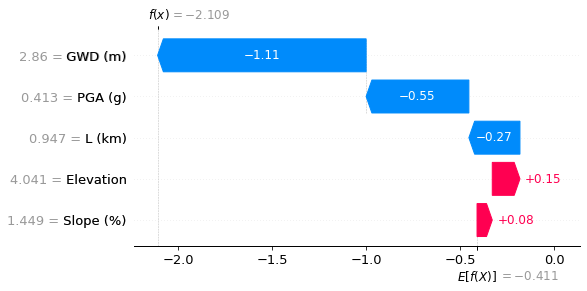

Sum of SHAP value:  -2.1091635


In [7]:
# visualize no lateral spreading prediction explanation
shap.plots.waterfall(shap_values[0])

# Sum of individual SHAP values + the mean base value yields the final result
print("Sum of SHAP value: ", np.sum(shap_values[0].values) + shap_values[0].base_values)

In [8]:
# visualize the no lateral spreading prediction's explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[0])

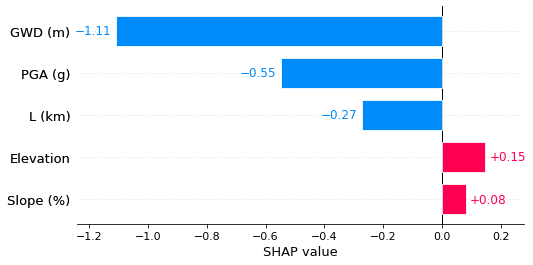

In [9]:
shap.plots.bar(shap_values[0])

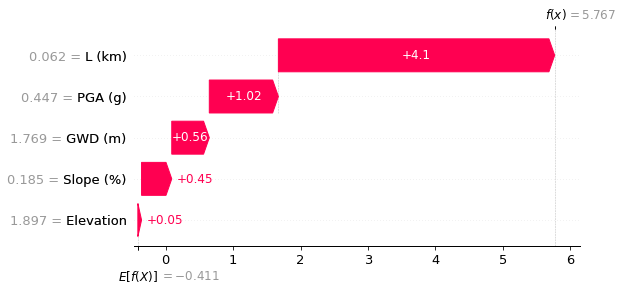

In [10]:
# visualize lateral spreading prediction's explanation
shap.plots.waterfall(shap_values[2])

In [11]:
# visualize lateral spreading explanation with a force plot
shap.initjs()
shap.plots.force(shap_values[2])

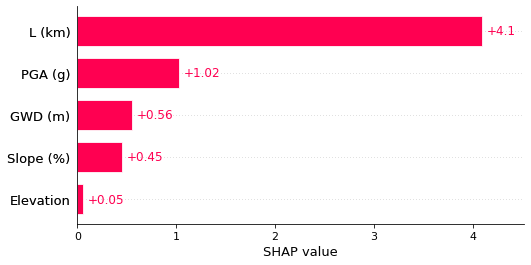

In [12]:
shap.plots.bar(shap_values[2])

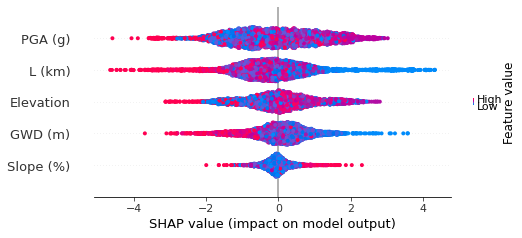

In [13]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

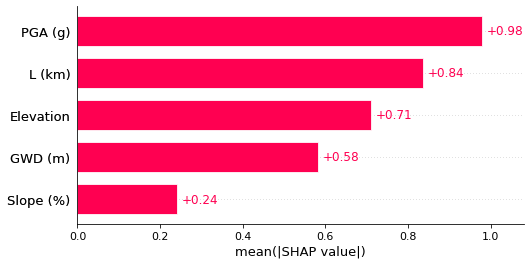

In [14]:
shap.plots.bar(shap_values)

# Feature relations

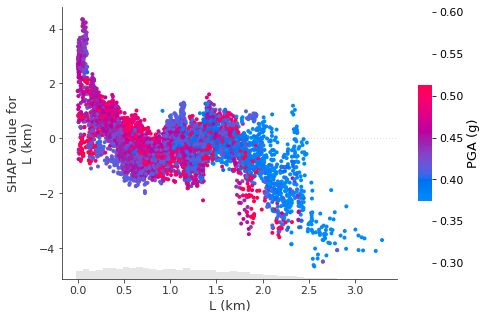

In [15]:
# create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:,"L (km)"], color=shap_values)

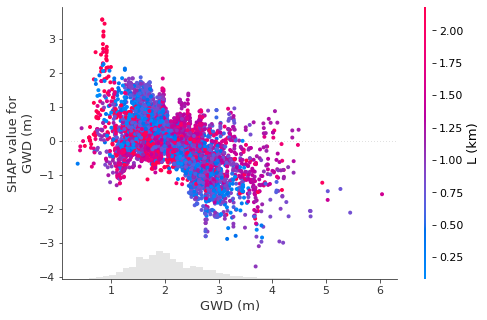

In [16]:
shap.plots.scatter(shap_values[:,"GWD (m)"], color=shap_values)

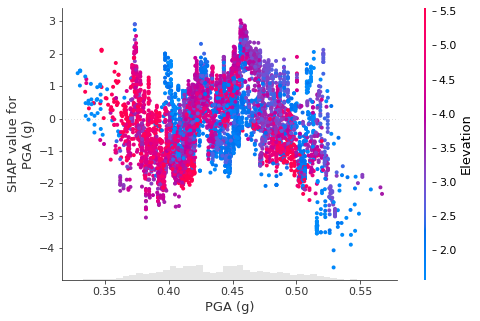

In [17]:
shap.plots.scatter(shap_values[:,"PGA (g)"], color=shap_values)

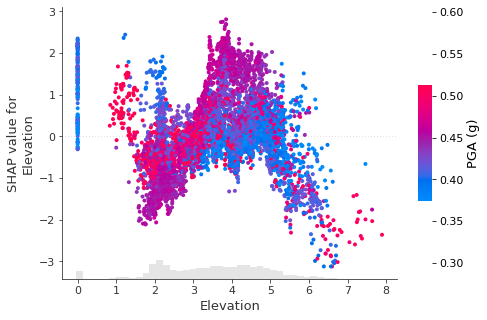

In [18]:
shap.plots.scatter(shap_values[:,"Elevation"], color=shap_values)

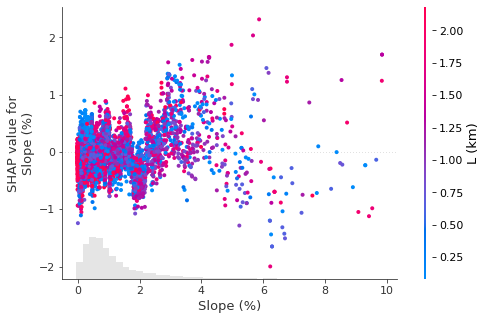

In [19]:
shap.plots.scatter(shap_values[:,"Slope (%)"], color=shap_values)

# Unsupervised clustering

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
from sklearn import cluster
from sklearn.datasets import make_blobs

import warnings
import sys

print("Python Version : ",sys.version)
print("Scikit-Learn Version : ",sklearn.__version__)

warnings.filterwarnings('ignore') ## We'll silent future warnings using this command.
np.set_printoptions(precision=3)

## Beow magic function fits plot inside of current notebook. 
## There is another option to it (%matplotlib notebook) which opens plot in new notebook.
%matplotlib inline

Python Version :  3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:13:55) 
[Clang 11.1.0 ]
Scikit-Learn Version :  1.0.2


In [22]:
# GWD datset
gwd = shap_values.data[:,0]
gwd_shap = shap_values.values[:,0]
gwd_shap_dataset = np.array(list(zip(gwd, gwd_shap)))
target = X_train_target['Target']

In [23]:
kmeans = cluster.KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_kmeans = kmeans.fit_predict(gwd_shap_dataset)

In [24]:
print('Cluster Centers : \n', str(kmeans.cluster_centers_))

Cluster Centers : 
 [[ 2.89  -0.89 ]
 [ 1.799  0.326]]


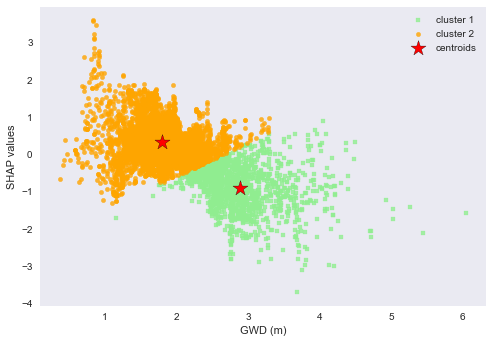

In [25]:
with plt.style.context(('ggplot', 'seaborn')):
    # plot the 2 clusters
    plt.scatter(
        gwd_shap_dataset[y_kmeans == 0, 0], gwd_shap_dataset[y_kmeans == 0, 1],
        s=20, c='lightgreen',
        marker='s', alpha = 0.8,
        label='cluster 1'
    )

    plt.scatter(
        gwd_shap_dataset[y_kmeans == 1, 0], gwd_shap_dataset[y_kmeans == 1, 1],
        s=20, c='orange',
        marker='o', alpha = 0.8,
        label='cluster 2'
    )

    # plot the centroids
    plt.scatter(
        kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
        s=250, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )
    plt.legend(scatterpoints=1)

    plt.xlabel('GWD (m)')
    plt.ylabel('SHAP values')
    plt.grid()
    plt.show()

### Scatter plot of GWD (m) vs SHAP values

The GWD is the first column of the SHAP values matrix.

In [26]:
# GWD datset
gwd = shap_values.data[:,0]
gwd_shap = shap_values.values[:,0]
gwd_shap_dataset = np.array(list(zip(gwd, gwd_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


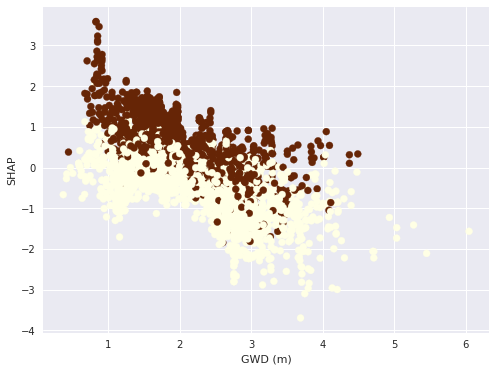

In [27]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(gwd, gwd_shap, c=target, cmap='YlOrBr')

    plt.xlabel('GWD (m)')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

### Distance to river

In [28]:
# GWD datset
l = shap_values.data[:,2]
l_shap = shap_values.values[:,2]
l_shap_dataset = np.array(list(zip(l, l_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


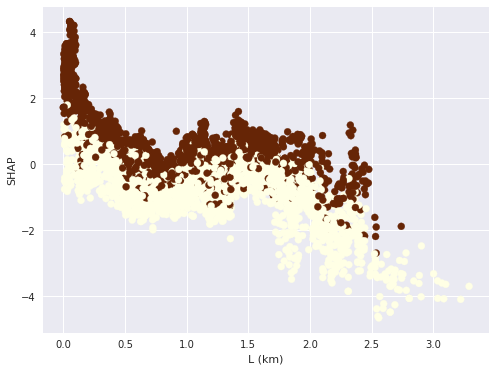

In [29]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(l, l_shap, c=target, cmap='YlOrBr')

    plt.xlabel('L (km)')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

### PGA SHAP values

In [30]:
# GWD datset
pga = shap_values.data[:,4]
pga_shap = shap_values.values[:,4]
pga_shap_dataset = np.array(list(zip(pga, pga_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


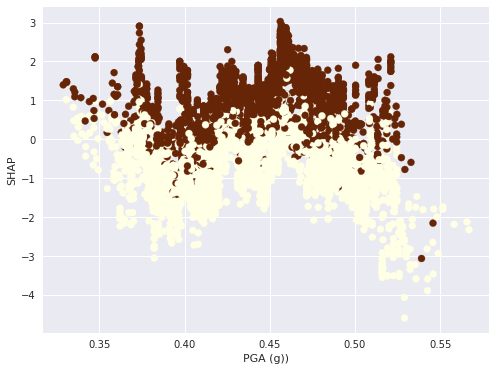

In [31]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pga, pga_shap, c=target, cmap='YlOrBr')

    plt.xlabel('PGA (g))')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

## Slope

In [32]:
# GWD datset
slope = shap_values.data[:,3]
slope_shap = shap_values.values[:,3]
slope_shap_dataset = np.array(list(zip(pga, pga_shap)))
target = X_train_target['Target']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


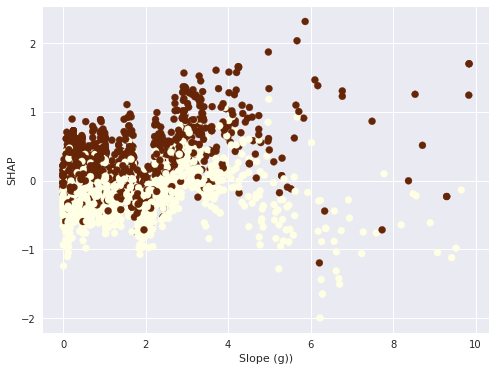

In [33]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(slope, slope_shap, c=target, cmap='YlOrBr')

    plt.xlabel('Slope (g))')
    plt.ylabel('SHAP')
    plt.legend(loc='best')

# PCA

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

xstd = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=3)
pcs = pca.fit_transform(xstd)
pcDf = pd.DataFrame(data = pcs, columns = ['PCA1', 'PCA2', 'PCA3'])
#pcDf = pd.concat([pcDf, target], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


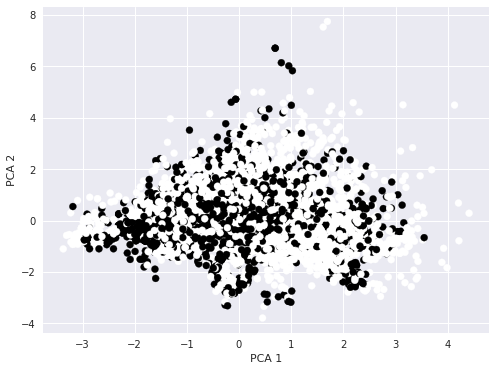

In [35]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pcDf['PCA1'], pcDf['PCA2'], c=target)

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend(loc='best')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


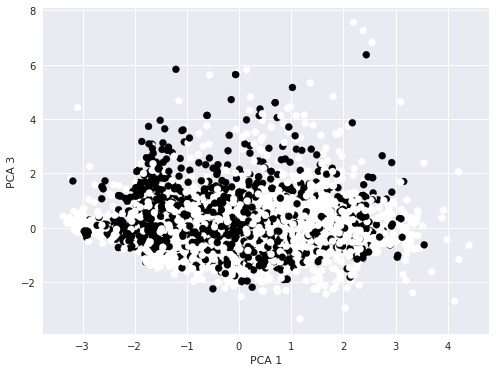

In [36]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pcDf['PCA1'], pcDf['PCA3'], c=target)

    plt.xlabel('PCA 1')
    plt.ylabel('PCA 3')
    plt.legend(loc='best')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


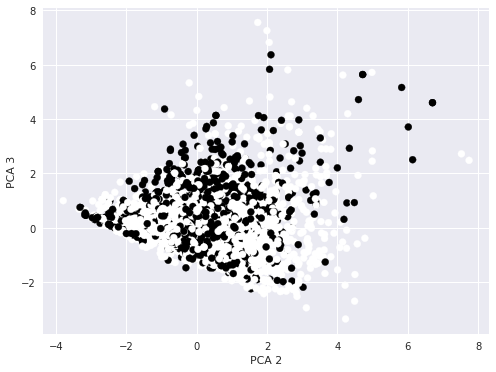

In [37]:
with plt.style.context(('ggplot', 'seaborn')):
    plt.figure(figsize=(8,6))
    plt.scatter(pcDf['PCA2'], pcDf['PCA3'], c=target)

    plt.xlabel('PCA 2')
    plt.ylabel('PCA 3')
    plt.legend(loc='best')

In [38]:
# Regression fit
pcmodel = xgboost.XGBClassifier().fit(pcDf, target)


[09:44:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643226991592/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
xstd_test = StandardScaler().fit_transform(X_test)
pca = PCA(n_components=3)
ptestcs = pca.fit_transform(xstd_test)
ptestDf = pd.DataFrame(data = ptestcs, columns = ['PCA1', 'PCA2', 'PCA3'])
xtest_target = X_test_target['Target']

In [40]:
# make prediction
preds = pcmodel.predict(ptestDf)
predictions = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(xtest_target, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 63.74%
